# Using machine learning to preprocess data fed into LLM.

## 1. Dataset analysis

The data consists of text from the user manual divided by the categories of information contained.

There will be two .csv files used:

* KTW airport guest manual
* WAW airport guest manual

Data will be merged into one DataFrame and then after preprocessing train and test sets will be created. Every category will be divided into 80% train and 20% test.

### 1) Imports

In [3]:
import pandas as pd
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) Loading needed data

In [16]:
file_path = '/content/drive/MyDrive/LLM_data_preprocessor/data_merged.xlsx'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} doesn't exist!")

try:
    merged_df = pd.read_excel(
        file_path,
        engine='openpyxl',
        usecols=['Text', 'Category'],
        dtype={'Text': 'str', 'Category': 'category'}
    ).dropna().reset_index(drop=True)

    if 'Page Number' in merged_df.columns:
        merged_df = merged_df.drop(columns='Page Number')
        print("Removed 'Page Number' column")

    assert {'Text', 'Category'}.issubset(merged_df.columns), "Required columns missing!"

    print("\n[SUMMARY]")
    print(f"Total documents: {len(merged_df)}")
    print(f"Unique categories ({len(merged_df.Category.unique())}):\n{merged_df.Category.value_counts()}")

    print("\n[SAMPLES]")
    print("Random text samples:")
    for i, row in merged_df.sample(3).iterrows():
        print(f"\nCATEGORY: {row['Category']}\nTEXT: {row['Text'][:150]}...")

except Exception as e:
    print(f"\n[ERROR] {str(e)}")
    if 'merged_df' in locals():
        print("\n[DEBUG] Partial data preview:")
        display(merged_df.head(2))
    raise

merged_df['Char_Length'] = merged_df['Text'].apply(len)
merged_df['Word_Count'] = merged_df['Text'].apply(lambda x: len(x.split()))

print("\n[TEXT STATISTICS]")
print(merged_df[['Char_Length', 'Word_Count']].describe().round(1))


[SUMMARY]
Total documents: 250
Unique categories (8):
Category
Parking Information                 101
Passenger Assistance and Support     70
General Information                  28
Business and Premium Services        13
Travel Guidelines                    13
Luggage and Baggage                  12
Security and Safety                   9
Commercial Services                   4
Name: count, dtype: int64

[SAMPLES]
Random text samples:

CATEGORY: Passenger Assistance and Support
TEXT: •  alcohol with concentration over 70 % (also forbidden in petrol fuel of self-
propelled machines) 
•  gases: propane, butane 
•  all types of contai...

CATEGORY: Parking Information
TEXT: Parking 
Book your parking space 
  
Convenient travel starts even before your flight! Book your parking space in advance and 
enjoy peace of mind bef...

CATEGORY: Parking Information
TEXT: 9 days  PLN 700 
10 days  PLN 750 
11 days  PLN 800 
12 days  PLN 850 
13 days  PLN 900 
14 days  PLN 950 
15 days  PLN 1 000 

In [17]:
# !python -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 13.0/20.2 MB 113.8 MB/s eta 0:00:01ERROR: Operation cancelled by user


### 3) Text cleaning -- if polish

In [21]:
from tqdm import tqdm
tqdm.pandas()

In [22]:
import re
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize tqdm for pandas
# tqdm.pandas()

# # Load Polish NLP model
# nlp = spacy.load('pl_core_news_sm')

# def preprocess_text(text):
#     """Improved preprocessing with error handling"""
#     try:
#         # Handle empty texts
#         if not isinstance(text, str) or len(text.strip()) == 0:
#             return ""

#         # Preserve airport codes and acronyms
#         text = re.sub(r'\b([A-Z]{3})\b', r' \1 ', text)

#         # Text normalization
#         text = re.sub(r'\d+[:.,]?\d*', ' ', text)
#         text = re.sub(r'[^\w\s]|_', ' ', text)

#         # SpaCy processing with timeout
#         doc = nlp(text.lower(), disable=['parser', 'ner'])
#         tokens = [
#             token.lemma_
#             for token in doc
#             if not token.is_stop
#             and not token.is_punct
#             and len(token.text) >= 2
#         ]

#         return ' '.join(tokens)

#     except Exception as e:
#         print(f"Error processing text: {str(e)}")
#         return ""

# # Apply preprocessing with progress bar
# merged_df['Clean_Text'] = merged_df['Text'].progress_apply(preprocess_text)

# # Check results
# print("\n[Examples of data after preprocessing]:")
# display(merged_df[['Text', 'Clean_Text']].sample(3))

Removing '\n' from data

In [24]:
merged_df['Text'] = merged_df['Text'].str.replace('\n', ' ')
# merged_df['Clean_Text'] = merged_df['Clean_Text'].str.replace('\n', ' ')
merged_df.head()

,Text,Category,Char_Length,Word_Count
0,Business Pass / Business Pass Premium – Terms ...,Business and Premium Services,794,113
1,Loyalty cards/invitations to the Executive Lou...,Business and Premium Services,529,70
2,"ONE WORLD EMERALD, QATAR AIRWAYS SAPPHIRE ...",Business and Premium Services,386,57
3,"CITI LOUNGE PASS, CITIGOLD SELECT CITIBANK ...",Business and Premium Services,428,61
4,PPL S.A. INVITATION,Business and Premium Services,20,3


### 4) Perform linguistic EDA -- most frequent words per category

In [32]:
merged_df = merged_df[merged_df['Text'].str.strip().str.len() > 0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-33-175697adb67f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Text'] = merged_df['Text'].apply(preprocess_english)
<ipython-input-33-175697adb67f>:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of 


Linguistic patterns analysis for 8 categories:

Category: Business and Premium Services
Number of documents: 13
Sample sentence: pln adult child aged child aged child night service cancellation less hour prior reservation selecte...


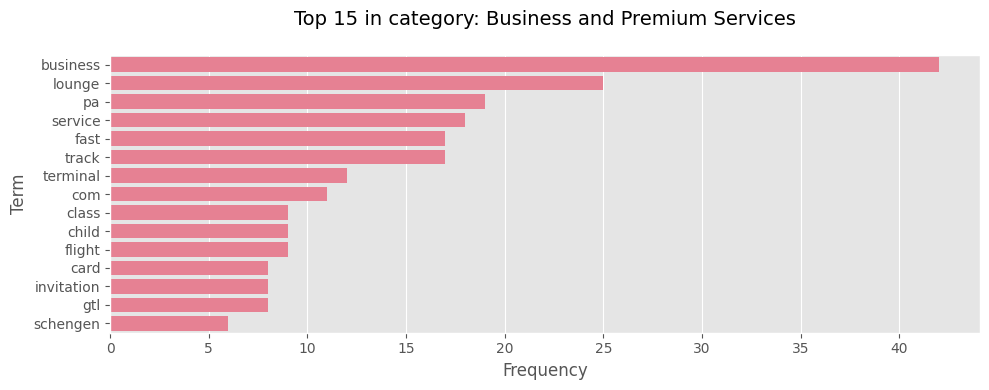


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 71.7%

Category: Commercial Services
Number of documents: 4
Sample sentence: contact executive lounge coordinator koordynatorzyexl ppl phone phone executive lounge preludium pho...


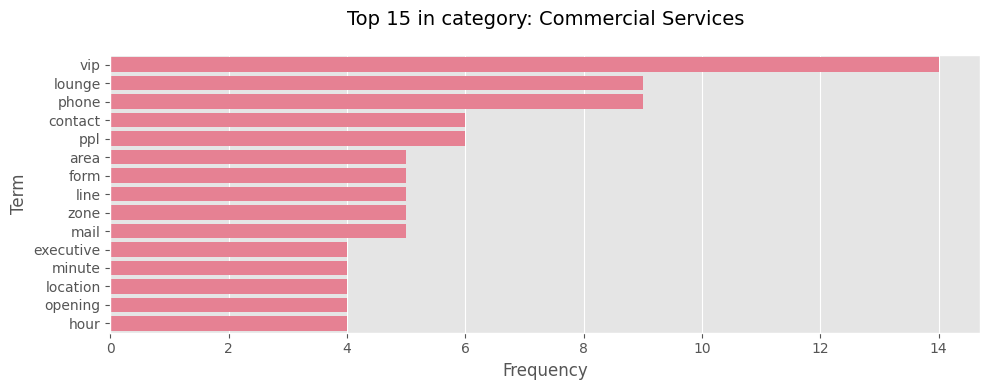


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 56.6%

Category: General Information
Number of documents: 28
Sample sentence: ecumenical chapel ecumenical chapel katowice airport opened april located second floor general acces...


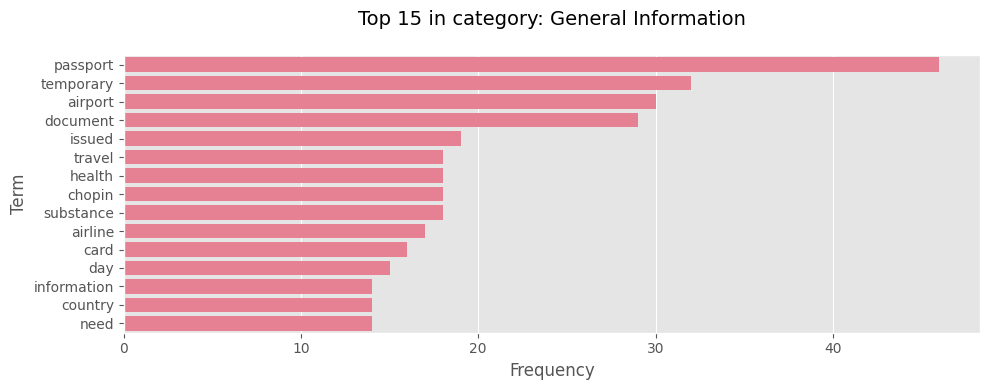


Linguistic statistics:
• Average word length: 6.3 characters
• Unique word ratio: 72.5%

Category: Luggage and Baggage
Number of documents: 12
Sample sentence: checked baggage travelling checked baggage check check point one check agent handle baggage provide ...


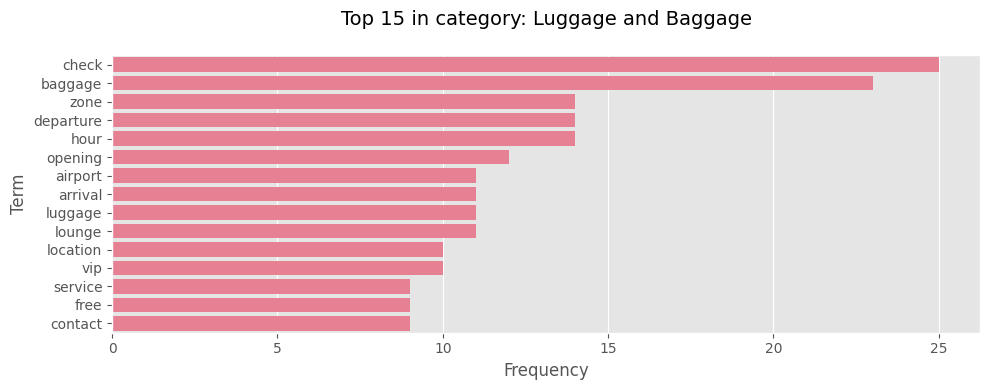


Linguistic statistics:
• Average word length: 6.3 characters
• Unique word ratio: 70.2%

Category: Parking Information
Number of documents: 100
Sample sentence: rate premium car park unguarded regular price list time ammount pln...


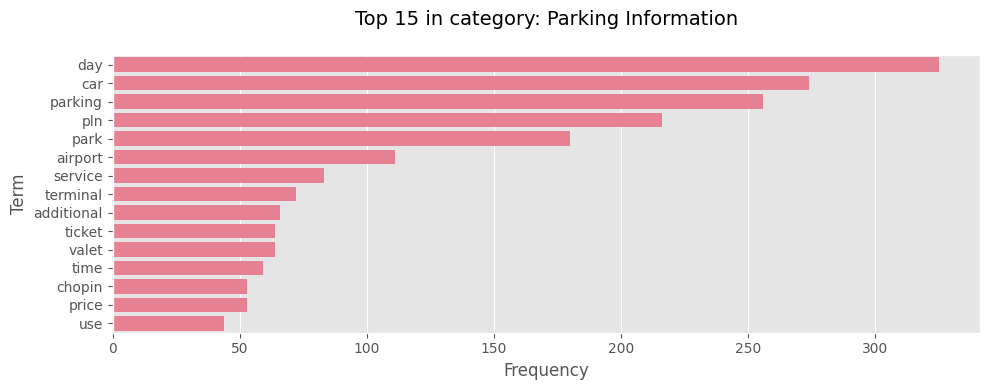


Linguistic statistics:
• Average word length: 5.1 characters
• Unique word ratio: 60.5%

Category: Passenger Assistance and Support
Number of documents: 70
Sample sentence: pharmacy enhance experience airport passenger personnel provide highest level convenience traveler p...


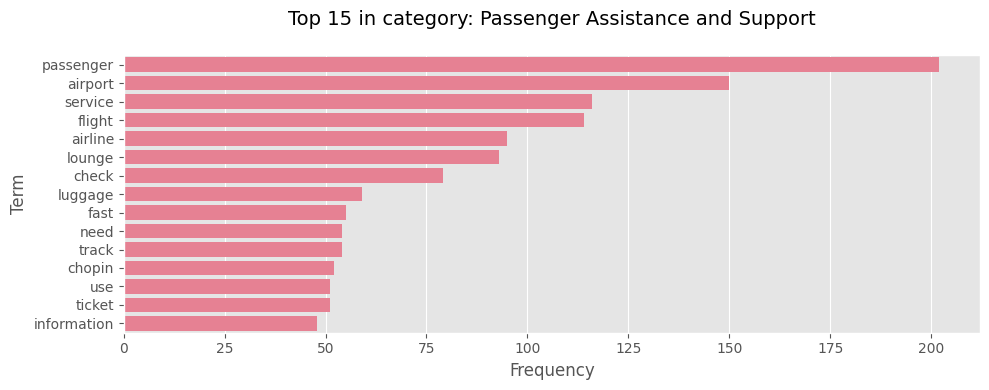


Linguistic statistics:
• Average word length: 6.5 characters
• Unique word ratio: 64.7%

Category: Security and Safety
Number of documents: 9
Sample sentence: individual present within airport premise obliged immediately inform border guard police airport sec...


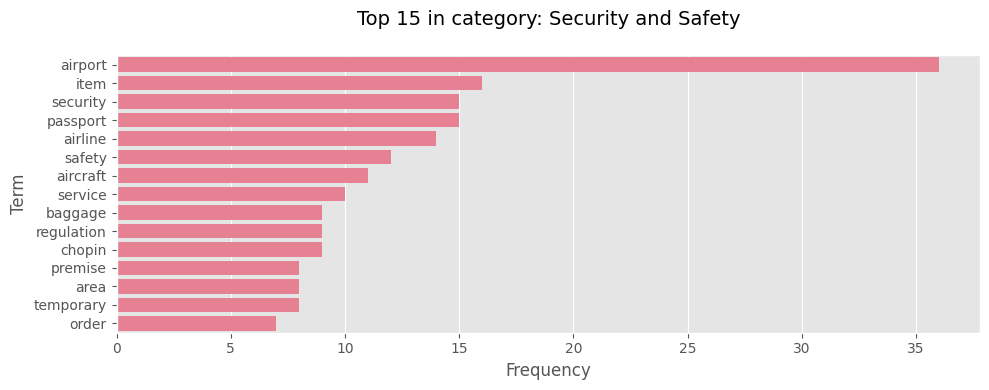


Linguistic statistics:
• Average word length: 6.6 characters
• Unique word ratio: 69.3%

Category: Travel Guidelines
Number of documents: 13
Sample sentence: mail info aelia pharmacy pharmacy location level arrival public area exit pll lot check counter open...


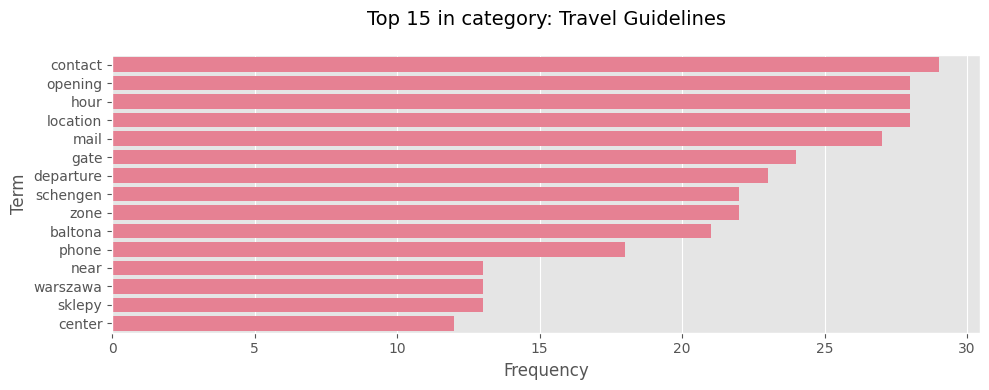


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 53.1%


[COMPARATIVE ANALYSIS]

Most distinctive terms per category (TF-IDF):

BUSINESS AND PREMIUM SERVICES:
department, service, fast, track, pa, com, gtl, invitation, lounge, business

COMMERCIAL SERVICES:
schengen, opening, area, gate, minute, ppl, executive, lounge, phone, vip

GENERAL INFORMATION:
code, travel, health, office, ehic, document, airline, www, temporary, passport

LUGGAGE AND BAGGAGE:
arrival, zone, departure, aelia, lounge, luggage, opening, landside, check, baggage

PARKING INFORMATION:
time, valet, ticket, price, additional, park, parking, car, pln, day

PASSENGER ASSISTANCE AND SUPPORT:
fast, business, pa, check, service, airline, flight, lounge, airport, passenger

SECURITY AND SAFETY:
premise, hand, airline, safety, security, passport, baggage, aircraft, airport, item

TRAVEL GUIDELINES:
phone, zone, schengen, hour, contact, gate, baltona, location, opening, mail


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK tools
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_english(text):
    """Basic English text preprocessing"""
    text = re.sub(r'\d+[:.,]?\d*', ' ', text)  # Remove numbers
    text = re.sub(r'[^\w\s]|_', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens
              if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

# Apply preprocessing to Text column
merged_df['Text'] = merged_df['Text'].apply(preprocess_english)

# Configure style
plt.style.use('ggplot')
sns.set_palette('husl')
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_category_wordcloud(category_text, category_name, n_words=15):
    """Generate frequency plot for specific category"""
    vec = CountVectorizer(max_features=n_words,
                         token_pattern=r'\b\w+\b',
                         stop_words='english')
    word_counts = vec.fit_transform(category_text).sum(axis=0)
    word_freq = [(word, word_counts[0, idx])
                for word, idx in vec.vocabulary_.items()]
    word_freq.sort(key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=[f[1] for f in word_freq],
                y=[f[0] for f in word_freq])
    plt.title(f'Top {n_words} in category: {category_name}\n', fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

# Group by category and analyze
category_groups = merged_df.groupby('Category')['Text']
print(f"\nLinguistic patterns analysis for {len(category_groups)} categories:")

# Plot for each category
for category_name, group in category_groups:
    print(f"\n{'='*50}\nCategory: {category_name}")
    print(f"Number of documents: {len(group)}")
    print("Sample sentence:", group.sample(1).values[0][:100] + "...")

    # Generate frequency plot
    plot_category_wordcloud(group, category_name)

    # Additional linguistic stats
    avg_word_length = group.apply(lambda x: np.mean([len(w) for w in x.split()])).mean()
    unique_word_ratio = group.apply(lambda x: len(set(x.split()))/len(x.split())).mean()
    print(f"\nLinguistic statistics:")
    print(f"• Average word length: {avg_word_length:.1f} characters")
    print(f"• Unique word ratio: {unique_word_ratio:.1%}")

# Cross-category analysis
print("\n\n[COMPARATIVE ANALYSIS]")
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(merged_df['Text'])

# Get most distinctive words using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merged_df['Text'])
feature_names = tfidf.get_feature_names_out()

category_terms = defaultdict(list)
for idx, category in enumerate(merged_df['Category'].unique()):
    mask = merged_df['Category'] == category
    avg_tfidf = tfidf_matrix[mask].mean(axis=0)
    top_indices = np.argsort(avg_tfidf.A).flatten()[-10:]
    category_terms[category] = [feature_names[i] for i in top_indices]

print("\nMost distinctive terms per category (TF-IDF):")
for cat, terms in category_terms.items():
    print(f"\n{cat.upper()}:")
    print(", ".join(terms))

### 5) Handle short texts strategy (if Word_Count < 10)

# 2. Model training

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import numpy as np

# TF-IDF Vectorizer with optimized parameters
tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

# Define models optimized for text classification
models = {
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20]
        }
    },
    'K-Neighbors': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'clf__alpha': [0.1, 0.5, 1.0]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    }
}

# Model training and evaluation with hyperparameter tuning
best_score = 0
best_model = None

for name, config in models.items():
    print(f"\n{'='*50}\nTraining {name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('clf', config['model'])
    ])

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid=config['params'],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Evaluate
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)

    print("\nClassification Report:")
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Track best model
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

# Save and analyze best model
print(f"\nBest model: {best_model.named_steps['clf'].__class__.__name__}")
print(f"Best F1 score: {best_score:.4f}")

# Feature importance for interpretable models
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    print("\nTop 10 features per class:")
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    importances = best_model.named_steps['clf'].feature_importances_
    top_indices = np.argsort(importances)[-10:]
    print(", ".join(feature_names[top_indices]))


Training Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters for Random Forest:
{'clf__max_depth': 10, 'clf__n_estimators': 200}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       1.00      0.67      0.80         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.71      0.83      0.77         6
             Luggage and Baggage       1.00      0.50      0.67         2
             Parking Information       0.95      0.95      0.95        20
Passenger Assistance and Support       0.82      1.00      0.90        14
             Security and Safety       1.00      1.00      1.00         2
               Travel Guidelines       0.00      0.00      0.00         2

                        accuracy                           0.86        50
                       macro avg       0.69      0.62      0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for K-Neighbors:
{'clf__n_neighbors': 7, 'clf__weights': 'distance'}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.50      0.33      0.40         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       1.00      0.33      0.50         6
             Luggage and Baggage       1.00      0.50      0.67         2
             Parking Information       0.90      0.90      0.90        20
Passenger Assistance and Support       0.54      0.93      0.68        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       0.00      0.00      0.00         2

                        accuracy                           0.70        50
                       macro avg       0.49      0.37      0.39        50
                    weighted avg       0.70      0.70      0.66        50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for Naive Bayes:
{'clf__alpha': 0.1}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.00      0.00      0.00         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       1.00      0.33      0.50         6
             Luggage and Baggage       1.00      0.50      0.67         2
             Parking Information       0.85      0.85      0.85        20
Passenger Assistance and Support       0.54      0.93      0.68        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       0.00      0.00      0.00         2

                        accuracy                           0.66        50
                       macro avg       0.42      0.33      0.34        50
                    weighted avg       0.65      0.66      0.62        50


Training SVM...
Fitting 3 fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for SVM:
{'clf__C': 1, 'clf__kernel': 'linear'}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       1.00      0.67      0.80         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.80      0.67      0.73         6
             Luggage and Baggage       1.00      0.50      0.67         2
             Parking Information       1.00      0.85      0.92        20
Passenger Assistance and Support       0.64      1.00      0.78        14
             Security and Safety       0.50      0.50      0.50         2
               Travel Guidelines       0.00      0.00      0.00         2

                        accuracy                           0.78        50
                       macro avg       0.62      0.52      0.55        50
                    weighted avg       0.79      0.78      0.77        50


Best model: RandomF

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3.Results

## What can be improved?
Increase the amount of data: Some classes (e.g., “Commercial Services”) have very few examples, making it difficult for models to learn.

Balancing classes: oversampling (e.g., SMOTE) or undersampling can be used.

Better preprocessing: Adding lemmatization, stop word removal, or TF-IDF adjustment.

Testing other models: We can try using XGBoost, LightGBM or neural networks (LSTM).